In [1]:
# 一些全局配置
config = {
    'is_train': False,  # 是否进行训练
    'is_save': False,  # 是否保存模型文件
    'is_load': True,  # 是否加载模型文件
    'is_save_result': True,  # 是否保存结果

    # 路径相关配置
    'cwd': '.',  # 工作路径
    'model_path': '/models/rnn.pth',  # 模型保存路径
    'result_data': '/data/result.txt',  # 结果保存路径
    'train_data': '/data/train_preprocessed.json',  # 训练数据
    'test_data': '/data/test_preprocessed.json',  # 测试数据
    'word_vectors': '/data/word_vectors_filtered.txt',  # 词向量

    # 训练数据划分相关配置
    'random_seed': 42,  # 随机种子
    'train_set_ratio': 0.9,  # 训练集占训练数据的比重
    'batch_size': 64,  # 训练批次
    'num_steps': 80,  # 填充

    # Model 相关配置
    'embed_size': 100,  # 嵌入层 size
    'num_hiddens': 120,
    'num_layers': 2,
    'h': lambda x: 1 / x ** 2,
    # 'dropout': 0.5,

    # 训练相关配置
    'lr': 0.01,
    'num_epochs': 15
}

In [2]:
# 当前是否是 google colab 中
is_colab = True
try:
    from google.colab import drive
except ImportError:
    is_colab = False
# 挂载 google drive
if is_colab:
    drive.mount('/content/drive')

# 为 Colab 更改对应配置
if is_colab:
    config = {
        **config,
        'is_train': True,
        'is_save': True,
        'is_load': False,
        'cwd': '/content/drive/MyDrive/Colab Notebooks/nlp-target-sentiment-analysis',
    }

In [3]:
# 为 Colab 安装对应依赖
if 'is_init' not in locals().keys() and is_colab:
    !pip install torch==1.12.0
    !pip install torchvision==0.13.0
    !pip insatll matplotlib==3.0
    !pip install matplotlib_inline==0.1.6
is_init = True

In [4]:
import torch
from torch import nn
import json
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import collections

In [5]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu().

    Defined in :numref:`sec_use_gpu`"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():
    """Return all available GPUs, or [cpu(),] if no GPU exists.

    Defined in :numref:`sec_use_gpu`"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences.

    Defined in :numref:`sec_machine_translation`"""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

numpy = lambda x, *args, **kwargs: x.detach().numpy(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
reshape = lambda x, *args, **kwargs: x.reshape(*args, **kwargs)
to = lambda x, *args, **kwargs: x.to(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
transpose = lambda x, *args, **kwargs: x.t(*args, **kwargs)

def accuracy(y_hat, y):
    """Compute the number of correct predictions.

    Defined in :numref:`sec_softmax_scratch`"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))

class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        # use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU.

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]

def count_corpus(tokens):
    """Count token frequencies.

    Defined in :numref:`sec_text_preprocessing`"""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        """Defined in :numref:`sec_text_preprocessing`"""
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs
    

In [6]:

def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     random.seed(seed)
    #  torch.backends.cudnn.deterministic = True

# 设置随机数种子
setup_seed(config['random_seed'])

In [7]:
class DataIter:
    """Construct a PyTorch data iterator."""

    def __init__(self, data_arrays, batch_size) -> None:
        self.features, self.labels = data_arrays
        self.batch_size = batch_size

    def __iter__(self):
        """Return the batch iterator and switch to the next epoch."""
        # 通过yield返回一个迭代器对象
        for i in range(0, len(self.features), self.batch_size):
            yield (self.features[i: i + self.batch_size], self.labels[i: i + self.batch_size])

    def __len__(self):
        """Return the number of batches."""
        return len(self.features) // self.batch_size


def load_data(batch_size, num_steps=80):
    with open(config['cwd'] + config['train_data'], 'r') as f:
        train_data = json.load(f)
    # 分出一部分训练数据作为验证集
    random.shuffle(train_data)
    test_data = train_data[:int(len(train_data) * (1 - config['train_set_ratio']))]
    train_data = train_data[int(len(train_data) * (1 - config['train_set_ratio'])):]
    train_tokens = [data['tokens'] for data in train_data]
    test_tokens = [data['tokens'] for data in test_data]
    train_dist = [data['dist'][1:] for data in train_data]
    test_dist = [data['dist'][1:] for data in test_data]
    # train_dist = [[1] * len(data['tokens']) for data in train_data]
    # test_dist = [[1] * len(data['tokens']) for data in test_data]
    train_labels = [int(data['label']) + 1 for data in train_data]
    test_labels = [int(data['label']) + 1 for data in test_data]
    vocab = Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([truncate_pad(
        vocab[train_tokens[i]], num_steps, vocab['<pad>']) + truncate_pad(
        train_dist[i], num_steps, 100) for i in range(len(train_tokens))])
    test_features = torch.tensor([truncate_pad(
        vocab[test_tokens[i]], num_steps, vocab['<pad>']) + truncate_pad(
        test_dist[i], num_steps, 100) for i in range(len(test_tokens))])
    train_iter = DataIter((train_features, torch.tensor(train_labels)),
                                batch_size)
    test_iter = DataIter((test_features, torch.tensor(test_labels)),
                               batch_size)
    return train_iter, test_iter, vocab

batch_size = config['batch_size']
num_steps = config['num_steps']
train_iter, test_iter, vocab = load_data(batch_size, num_steps)

In [8]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, h=lambda x: 1 / x ** 2, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.h = h
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 3)

    def forward(self, inputs):
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        # 一半作为 inputs, 一半作为 dist
        shape = inputs.shape
        dist = inputs[:, shape[1]//2:]
        inputs = inputs[:, :shape[1]//2]
        # 通过 self.h 处理得到 weights
        weights = self.h(dist)
        embeddings = self.embedding(inputs.T)
        # 通过 weights 乘上 embeddings 得到加权后的 embeddings
        weights = weights.T
        weights = weights.reshape(weights.shape[0], weights.shape[1], 1)
        embeddings = embeddings * weights
        self.encoder.flatten_parameters()
        # 返回上一个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        outputs, _ = self.encoder(embeddings)
        # 连结初始和最终时间步的隐状态，作为全连接层的输入，
        # 其形状为（批量大小，4*隐藏单元数）
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [9]:
embed_size, num_hiddens, num_layers, h = config['embed_size'], config['num_hiddens'], config['num_layers'], config['h']
devices = try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers, h=h)

In [10]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights)

BiRNN(
  (embedding): Embedding(1447, 100)
  (encoder): LSTM(100, 120, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=480, out_features=3, bias=True)
)

为词表中的单词加载预训练的100维（需要与`embed_size`一致）的GloVe嵌入。

In [11]:
class TokenEmbedding:
    """Token Embedding."""
    def __init__(self):
        """Defined in :numref:`sec_synonyms`"""
        self.idx_to_token, self.idx_to_vec = self._load_embedding()
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self):
        idx_to_token, idx_to_vec = ['<unk>'], []
        word_vec_dir = config['cwd'] + config['word_vectors']
        # GloVe website: https://nlp.stanford.edu/projects/glove/
        # fastText website: https://fasttext.cc/
        with open(word_vec_dir, 'r') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # Skip header information, such as the top row in fastText
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

glove_embedding = TokenEmbedding()

In [12]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([1447, 100])

In [13]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

KeyboardInterrupt: 

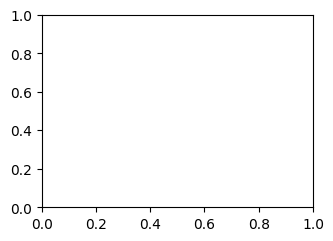

In [14]:
lr, num_epochs = config['lr'], config['num_epochs']
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

def train_batch(net, X, y, loss, trainer, devices):
    """Train for a minibatch with mutiple GPUs (defined in Chapter 13).

    Defined in :numref:`sec_image_augmentation`"""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=try_all_gpus()):
    """Train a model with mutiple GPUs (defined in Chapter 13).

    Defined in :numref:`sec_image_augmentation`"""
    timer, num_batches = Timer(), len(train_iter)
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

if config['is_train']:
    train(net, train_iter, test_iter, loss, trainer, num_epochs,
        devices)

In [ ]:
def predict(net, vocab, sequence):
    """预测文本序列的情感"""
    inputs = vocab[sequence.split()]
    inputs = truncate_pad(inputs, num_steps, vocab['<pad>']) + [1] * num_steps
    sequence = torch.tensor(inputs, device=try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return label

def predict_sentiment(net, vocab, sequence):
    label = predict(net, vocab, sequence)
    return 'positive' if label == 2 else ('neutral' if label == 1 else 'negative')

In [ ]:
predict_sentiment(net, vocab, 'this movie is so great')

'neutral'

In [ ]:
predict_sentiment(net, vocab, 'this movie is so bad')

'neutral'

In [ ]:
# 保存模型

if config['is_save']:
    torch.save(net.state_dict(), config['cwd'] + config['model_path'])

In [ ]:
# 生成最终的结果文件 `result.txt`.

if config['is_save_result']:
    result = []
    with open(config['cwd'] + config['test_data']) as f:
        test_data = json.load(f)
        test_tokens = [data['tokens'] for data in test_data]
        test_dist = [data['dist'][1:] for data in test_data]
        test_features = torch.tensor([truncate_pad(
            vocab[test_tokens[i]], num_steps, vocab['<pad>']) + truncate_pad(
            test_dist[i], num_steps, 100) for i in range(len(test_tokens))])
        test_labels = net(test_features.to(try_gpu())).argmax(dim=1).cpu().numpy()
        # 0 -> -1, 1 -> 0, 2 -> 1
        result = [label - 1 for label in test_labels]
    with open(config['cwd'] + config['result_data'], 'w') as f:
        for label in result:
            f.write(str(label) + '\n')